# 2048 Reinforcement learning

In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from model.game import Game2048
from player import play_many

## Random strategie

In [3]:
class RandomStrategy:
    def get_action(self, game):
        return np.random.randint(4)

In [4]:
%%time

strategy = RandomStrategy()

df = play_many(10000, strategy)

CPU times: user 1min 40s, sys: 210 ms, total: 1min 40s
Wall time: 1min 40s


In [5]:
df.describe()

,score,max_tile,moves
count,10000.000000,10000.000000,10000.000000
mean,1099.171600,107.924800,140.962000
std,537.778348,56.014749,46.914928
min,108.000000,16.000000,38.000000
25%,676.000000,64.000000,105.000000
50%,1052.000000,128.000000,136.000000
75%,1364.000000,128.000000,169.000000
max,5220.000000,512.000000,433.000000


In [6]:
df.moves.sum()

1409620

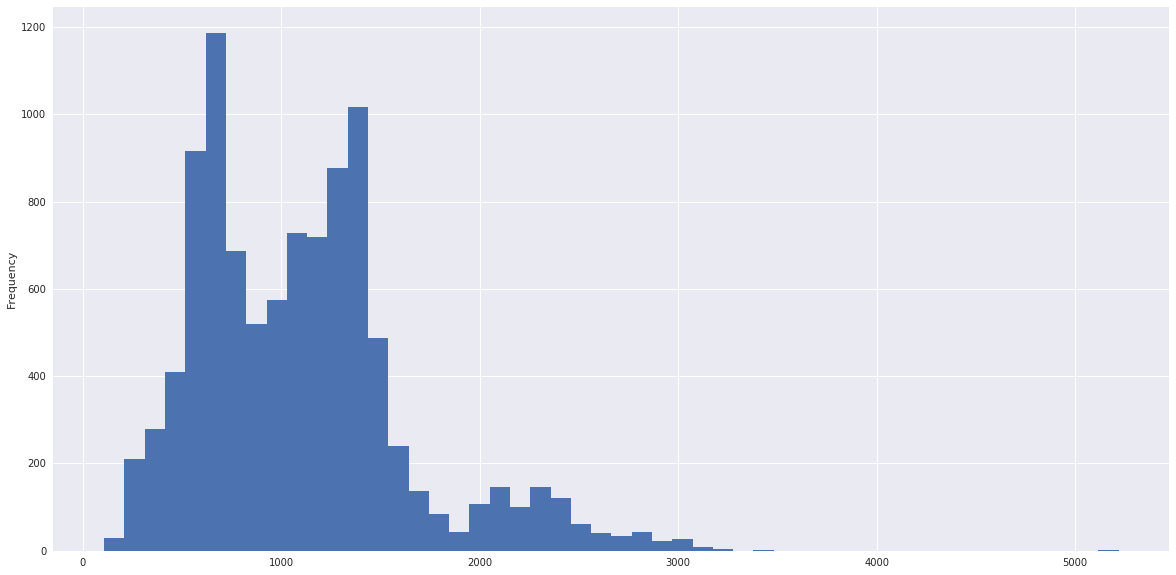

In [7]:
df.score.plot(kind='hist', bins=50)

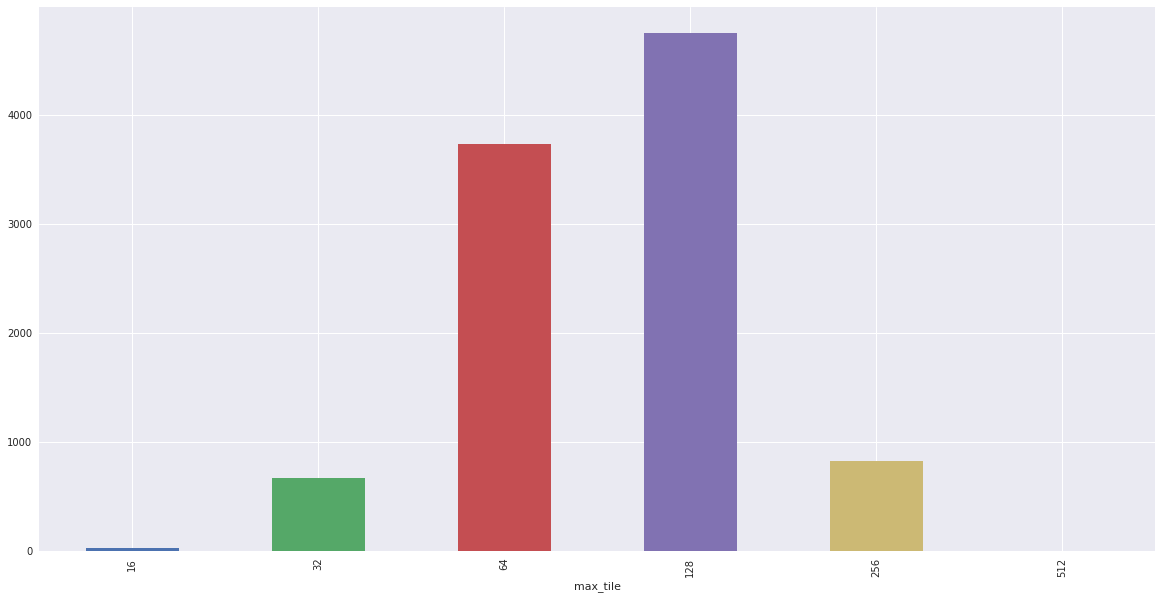

In [8]:
df.groupby(df.max_tile).score.count().plot.bar()

In [9]:
df.groupby(df.max_tile).score.count()

max_tile
16       27
32      671
64     3731
128    4749
256     821
512       1
Name: score, dtype: int64